In [119]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import datetime
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay

### Explanation

* 다음 날 등락률이 0보다 크면 1, 아니면 0으로 binary classification
* delisted == 0인 것 중 SDate가 2020-01-01보다 작은 주식 대상
* 훈련 기간: 2020-01-01 ~ 2022-12-31, 테스트 기간: 2023-01-01 ~ 2023-05-01
* 20일 전까지의 등락률 만으로 다음 날 등락률 예측.

In [9]:
stock_list = pd.read_csv('DB/stock_list.csv', parse_dates=['SDate', 'EDate'])
stock_list.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4023 entries, 0 to 4022
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Code      4023 non-null   object        
 1   Name      4023 non-null   object        
 2   Delisted  4023 non-null   int64         
 3   Kospi     4023 non-null   int64         
 4   SDate     4023 non-null   datetime64[ns]
 5   EDate     4023 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 157.2+ KB


In [13]:
stock_list = stock_list[stock_list['Delisted'] == 0]
stock_list = stock_list[stock_list['SDate'] < datetime.datetime(2020,1,1)]
stock_list.head()

,Code,Name,Delisted,Kospi,SDate,EDate
1,000020,동화약품,0,1,2000-01-04,2023-05-02
4,000040,KR모터스,0,1,2000-01-04,2023-05-02
5,000050,경방,0,1,2000-01-04,2023-05-02
7,000070,삼양홀딩스,0,1,2000-01-04,2023-05-02
8,000075,삼양홀딩스우,0,1,2000-01-04,2023-05-02


In [143]:
l = []
for i in [np.random.randint(0, 2228) for _ in range(5)]:  # np.random.randint(0, 2228)
    ser = stock_list.iloc[i]; x = []; y = []
    path = f"DB/BackTesting/{ser['Code']} {ser['Name']}.csv"
    df = pd.read_csv(path)
    cv = TimeSeriesSplit(n_splits=len(df)-21, max_train_size=20, test_size=1)
    for train_index, test_index in cv.split(df['Change']):
        x.append(df['Change'][train_index].reset_index(drop=True).rename(df['Date'][test_index].values[0]))
        y.append(df['Change'][test_index].values[0] > 2)
    X = pd.concat(x, axis=1).T
    y = np.array(y)
    l.append(train_test_split(X, y, test_size=0.05, shuffle=False))
    
X_train = pd.concat([(lambda x:x[0])(l[i]) for i in range(len(l))])
X_test = pd.concat([(lambda x:x[1])(l[i]) for i in range(len(l))])
y_train = np.hstack([(lambda x:x[2])(l[i]) for i in range(len(l))])
y_test = np.hstack([(lambda x:x[3])(l[i]) for i in range(len(l))])

In [94]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, shuffle=False)

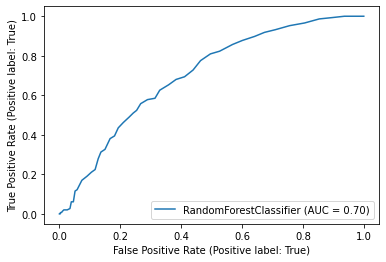

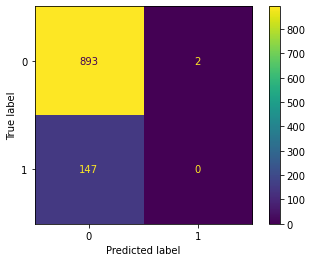

In [154]:
model = RandomForestClassifier()  #VotingClassifier([(str(i), SVC(probability=True)) for i in range(10)], voting='soft')
model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)
RocCurveDisplay.from_estimator(model, X_test, y_test)
y_pred_proba = y_pred_proba[:,1]; y_pred = y_pred_proba > 0.5
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

In [160]:
len(y_train)

19765